**Import the necessary libraries**

In [9]:
import os
import collections
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.sparse as sp
import torch
from torch import Tensor
import torch_geometric
from torch_geometric.utils import to_networkx
from torch_geometric.datasets import Planetoid
import networkx as nx
from networkx.algorithms import community
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
from torch_geometric.datasets import Planetoid
import matplotlib.pyplot as plt
import torch
from torch_geometric.nn import GATConv
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import pandas as pd
import collections

**Preprocessing of data**

In [10]:
# Specify the dataset name and root directory
dataset_name = 'Cora'
root_dir = './data'

# Load the Cora dataset
dataset = Planetoid(root=root_dir, name=dataset_name)

# Get the first graph object in the dataset
data = dataset[0]

# Print dataset information
print(f'Dataset: {dataset}')
print(f'Number of graphs: {len(dataset)}')
print(f'Number of features: {dataset.num_features}')
print(f'Number of classes: {dataset.num_classes}')
print(data)


Dataset: Cora()
Number of graphs: 1
Number of features: 1433
Number of classes: 7
Data(x=[2708, 1433], edge_index=[2, 10556], y=[2708], train_mask=[2708], val_mask=[2708], test_mask=[2708])


In [11]:
# Get the node features, edge indices, and target labels
x = dataset[0].x  # Node features
edge_index = dataset[0].edge_index  # Edge indices
y = dataset[0].y  # Target labels
# Normalize node features (optional)
x = x / x.sum(1, keepdim=True).clamp(min=1)

# Convert to PyTorch tensors
x = torch.FloatTensor(x)
edge_index = torch.LongTensor(edge_index)
y = torch.LongTensor(y)

# Print tensor shapes
print(f'Node features shape: {x.size()}')
print(f'Edge indices shape: {edge_index.size()}')
print(f'Target labels shape: {y.size()}')

Node features shape: torch.Size([2708, 1433])
Edge indices shape: torch.Size([2, 10556])
Target labels shape: torch.Size([2708])


In [12]:
print(f'Has isolated nodes: {data.has_isolated_nodes()}')  # False
print(f'Has self-loops: {data.has_self_loops()}')  # False
print(f'Is undirected: {data.is_undirected()}')  # True

Has isolated nodes: False
Has self-loops: False
Is undirected: True


In [13]:
print(f'Average node degree: {data.num_edges / data.num_nodes:.2f}')
# Average node degree: 3.90

Average node degree: 3.90


,count,mean,std,min,25%,50%,75%,max
0,2708.0,3.9,5.23,1.0,2.0,3.0,5.0,168.0


2708
10556


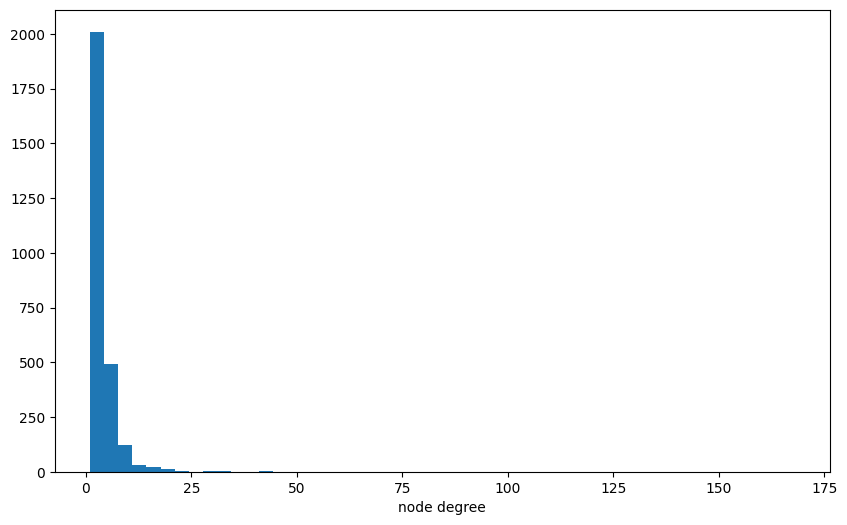

In [14]:
# Convert the PyTorch geometric dataset to a NetworkX graph
G = to_networkx(data, to_undirected=True)

# Calculate the degrees of each node in the graph
degrees = [val for (node, val) in G.degree()]

# Display summary statistics of the node degrees
display(pd.DataFrame(pd.Series(degrees).describe()).transpose().round(2))

# Print the total number of nodes in the graph
print(len(degrees))

# Print the sum of all node degrees in the graph
print(sum(degrees))

# Plot a histogram of the node degrees
plt.figure(figsize=(10, 6))
plt.hist(degrees, bins=50)
plt.xlabel("node degree")
plt.show()


threshold 0.011821204285186553


/usr/local/lib/python3.10/dist-packages/networkx/drawing/nx_pylab.py:450: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  node_collection = ax.scatter(


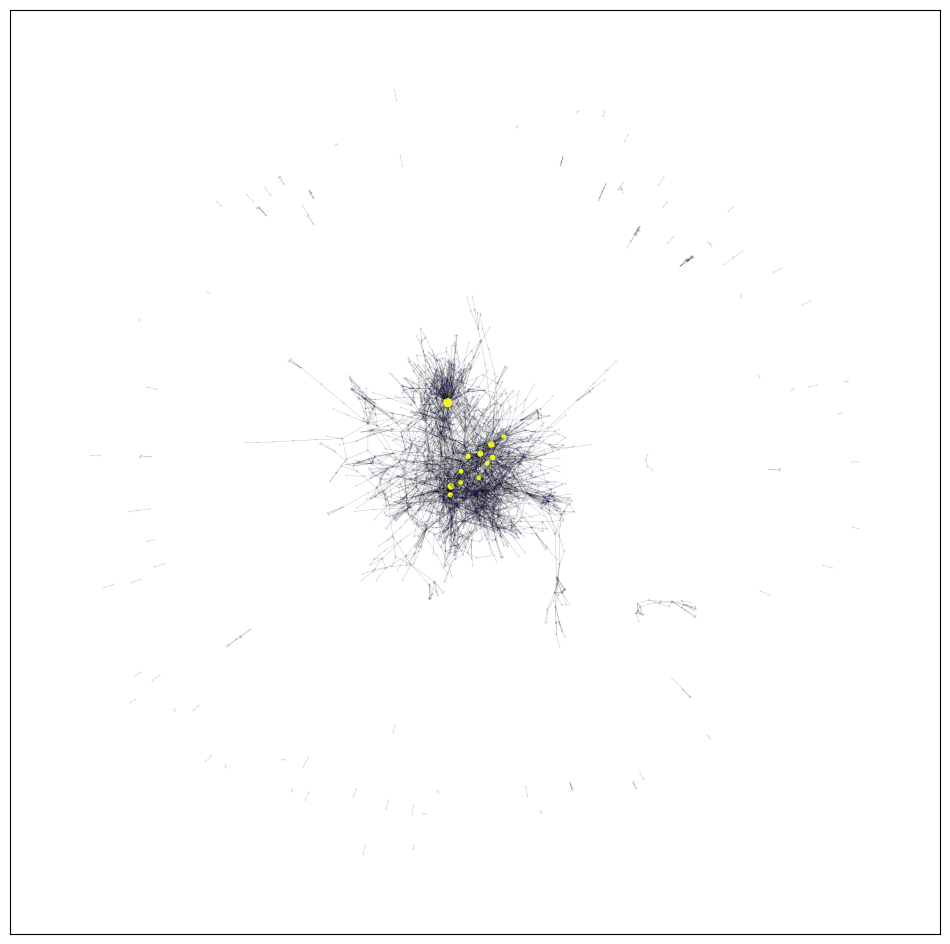

In [15]:
# Convert the PyTorch geometric dataset to a NetworkX graph
G = to_networkx(data, to_undirected=True)

# Generate the layout for the graph
pos = nx.spring_layout(G, seed=42)

# Calculate the degree centrality of each node
cent = nx.degree_centrality(G)

# Set the size of each node based on its degree centrality
node_size = list(map(lambda x: x * 500, cent.values()))

# Convert degree centrality values to a numpy array for thresholding
cent_array = np.array(list(cent.values()))

# Set a threshold to differentiate nodes based on degree centrality
threshold = sorted(cent_array, reverse=True)[10]
print("threshold", threshold)

# Create a binary array indicating whether each node's centrality is above the threshold
cent_bin = np.where(cent_array >= threshold, 1, 0.1)

# Plot the graph
plt.figure(figsize=(12, 12))
nodes = nx.draw_networkx_nodes(G, pos, node_size=node_size,
                               cmap=plt.cm.plasma,
                               node_color=cent_bin,
                               nodelist=list(cent.keys()),
                               alpha=cent_bin)
edges = nx.draw_networkx_edges(G, pos, width=0.25, alpha=0.3)
plt.show()

Number of classes: 7
{3: 818, 4: 426, 0: 351, 2: 418, 1: 217, 5: 298, 6: 180}


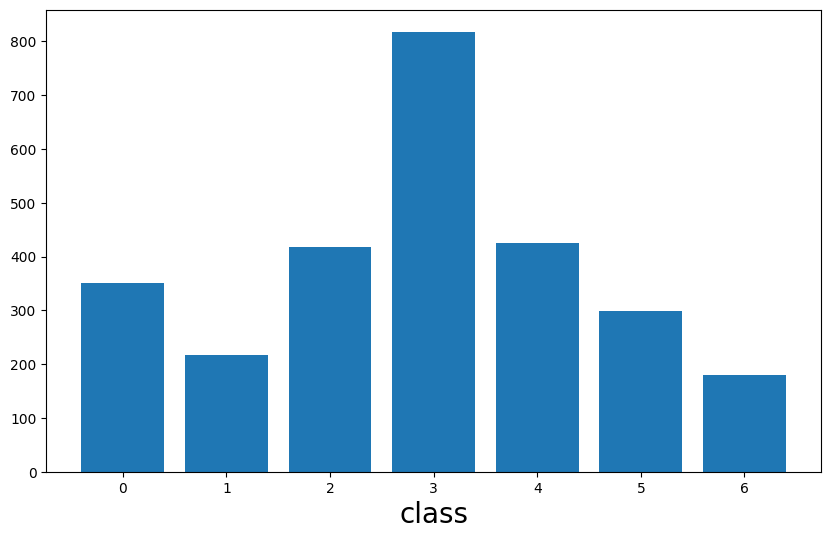

label: 0
1527 edges
{0: 1068, 3: 161, 5: 75, 4: 88, 1: 32, 6: 80, 2: 23}
label: 1
1029 edges
{0: 32, 1: 818, 2: 62, 6: 2, 5: 28, 3: 67, 4: 20}
label: 2
1826 edges
{3: 53, 2: 1654, 5: 30, 0: 23, 1: 62, 4: 2, 6: 2}
label: 3
2838 edges
{3: 2350, 4: 137, 0: 161, 5: 54, 1: 67, 2: 53, 6: 16}
label: 4
1592 edges
{4: 1320, 3: 137, 0: 88, 1: 20, 6: 6, 5: 19, 2: 2}
label: 5
1086 edges
{5: 834, 3: 54, 6: 46, 0: 75, 1: 28, 2: 30, 4: 19}
label: 6
658 edges
{6: 506, 0: 80, 3: 16, 5: 46, 4: 6, 1: 2, 2: 2}


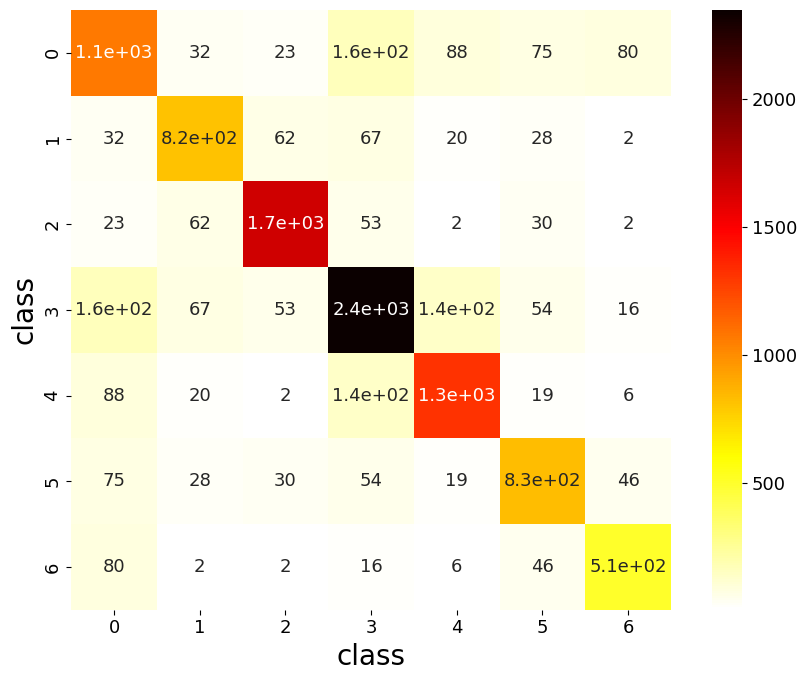

In [16]:
# Print the number of classes in the dataset
print(f'Number of classes: {dataset.num_classes}')

# Define a dictionary mapping class indices to class labels
label_dict = {
    0: "Theory",
    1: "Reinforcement_Learning",
    2: "Genetic_Algorithms",
    3: "Neural_Networks",
    4: "Probabilistic_Methods",
    5: "Case_Based",
    6: "Rule_Learning"}

# Display the first 10 target labels
data.y[:10]

# Count the occurrences of each class label
counter = collections.Counter(data.y.numpy())
counter = dict(counter)
print(counter)

# Sort the class labels and counts
count = [x[1] for x in sorted(counter.items())]

# Plot a bar chart of class label counts
plt.figure(figsize=(10, 6))
plt.bar(range(7), count)
plt.xlabel("class", size=20)
plt.show()

# Extract node labels and connected node labels
labels = data.y.numpy()
connected_labels_set = list(map(lambda x: labels[x], data.edge_index.numpy()))
connected_labels_set = np.array(connected_labels_set)

# Function to add missing keys to a dictionary
def add_missing_keys(counter, classes):
    for x in classes:
        if x not in counter.keys():
            counter[x] = 0
    return counter

# Calculate the counts of connected nodes for each class
label_connection_counts = []
for i in range(7):
    print(f"label: {i}")
    connected_labels = connected_labels_set[:, np.where(connected_labels_set[0] == i)[0]]
    print(connected_labels.shape[1], "edges")
    counter = collections.Counter(connected_labels[1])
    counter = dict(counter)
    print(counter)
    counter = add_missing_keys(counter, range(7))
    items = sorted(counter.items())
    items = [x[1] for x in items]
    label_connection_counts.append(items)
label_connection_counts = np.array(label_connection_counts)

# Plot a heatmap of the connected node counts between classes
plt.figure(figsize=(9, 7))
plt.rcParams["font.size"] = 13
hm = sns.heatmap(label_connection_counts, annot=True, cmap='hot_r', cbar=True, square=True)
plt.xlabel("class",size=20)
plt.ylabel("class",size=20)
plt.tight_layout()
plt.show()


**GCN Model**

In [18]:
import torch
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
from sklearn.metrics import precision_score, recall_score, f1_score

# Define the model
class GCN(torch.nn.Module):
    def __init__(self, hidden_channels):
        """
        Initialize the GCN model.

        Args:
            hidden_channels (int): Number of hidden channels in the GCN layers.
        """
        super(GCN, self).__init__()
        self.conv1 = GCNConv(dataset.num_features, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, hidden_channels)
        self.conv3 = GCNConv(hidden_channels, dataset.num_classes)

    def forward(self, x, edge_index):
        """
        Perform a forward pass through the GCN model.

        Args:
            x (Tensor): Node features.
            edge_index (LongTensor): Edge indices.

        Returns:
            Tensor: Predicted log probabilities.
        """
        x = F.relu(self.conv1(x, edge_index))
        x = F.dropout(x, training=self.training)
        x = F.relu(self.conv2(x, edge_index))
        x = F.dropout(x, training=self.training)
        x = self.conv3(x, edge_index)
        return F.log_softmax(x, dim=1)

# Initialize the model and move it to the appropriate device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = GCN(hidden_channels=64).to(device)
data = dataset[0].to(device)

# Split the dataset into training and test sets
num_nodes = data.num_nodes
torch.manual_seed(12345)
perm = torch.randperm(num_nodes)
split_idx = int(num_nodes * 0.8)
train_idx = perm[:split_idx]
test_idx = perm[split_idx:]

data.train_mask = torch.zeros(num_nodes, dtype=torch.bool)
data.train_mask[train_idx] = 1
data.test_mask = torch.zeros(num_nodes, dtype=torch.bool)
data.test_mask[test_idx] = 1

optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)

train_losses = []
test_losses = []
accuracies = []
precisions = []
recalls = []
f1_scores = []

def train():
    """
    Perform one training iteration.

    Returns:
        float: The training loss.
    """
    model.train()
    optimizer.zero_grad()
    out = model(data.x, data.edge_index)
    loss = F.nll_loss(out[data.train_mask], data.y[data.train_mask])
    loss.backward()
    optimizer.step()
    return loss.item()

def test():
    """
    Evaluate the model on the test set.

    Returns:
        tuple: A tuple containing the test loss, accuracy, predicted labels, and true labels.
    """
    model.eval()
    out = model(data.x, data.edge_index)
    pred = out.argmax(dim=1)
    test_loss = F.nll_loss(out[data.test_mask], data.y[data.test_mask]).item()
    acc = (pred[data.test_mask] == data.y[data.test_mask]).sum().item() / data.test_mask.sum().item()
    return test_loss, acc, pred[data.test_mask], data.y[data.test_mask]

# Training loop
for epoch in range(1, 201):
    train_loss = train()
    test_loss, acc, pred, true = test()
    train_losses.append(train_loss)
    test_losses.append(test_loss)
    accuracies.append(acc)

    # Calculate additional metrics
    precision = precision_score(true.cpu(), pred.cpu(), average='weighted')
    recall = recall_score(true.cpu(), pred.cpu(), average='weighted')
    f1 = f1_score(true.cpu(), pred.cpu(), average='weighted')

    precisions.append(precision)
    recalls.append(recall)
    f1_scores.append(f1)

    print(f'Epoch: {epoch:03d}, Loss: {train_loss:.4f}, Accuracy: {acc:.4f}')
    print(f'Precision: {precision:.4f}, Recall: {recall:.4f}, F1 Score: {f1:.4f}')



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 001, Loss: 1.9624, Accuracy: 0.4096
Precision: 0.4886, Recall: 0.4096, F1 Score: 0.2943
Epoch: 002, Loss: 1.8378, Accuracy: 0.3542
Precision: 0.3734, Recall: 0.3542, F1 Score: 0.2279
Epoch: 003, Loss: 1.7024, Accuracy: 0.4207
Precision: 0.5174, Recall: 0.4207, F1 Score: 0.3242


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 004, Loss: 1.5458, Accuracy: 0.5886
Precision: 0.6346, Recall: 0.5886, F1 Score: 0.5190
Epoch: 005, Loss: 1.3447, Accuracy: 0.7177
Precision: 0.6842, Recall: 0.7177, F1 Score: 0.6593
Epoch: 006, Loss: 1.1188, Accuracy: 0.7638
Precision: 0.8064, Recall: 0.7638, F1 Score: 0.7192
Epoch: 007, Loss: 0.9318, Accuracy: 0.7989
Precision: 0.8290, Recall: 0.7989, F1 Score: 0.7888
Epoch: 008, Loss: 0.7478, Accuracy: 0.8321
Precision: 0.8468, Recall: 0.8321, F1 Score: 0.8305
Epoch: 009, Loss: 0.6272, Accuracy: 0.8616
Precision: 0.8685, Recall: 0.8616, F1 Score: 0.8615
Epoch: 010, Loss: 0.5336, Accuracy: 0.8616
Precision: 0.8682, Recall: 0.8616, F1 Score: 0.8620
Epoch: 011, Loss: 0.4801, Accuracy: 0.8616
Precision: 0.8671, Recall: 0.8616, F1 Score: 0.8617
Epoch: 012, Loss: 0.4425, Accuracy: 0.8672
Precision: 0.8726, Recall: 0.8672, F1 Score: 0.8672
Epoch: 013, Loss: 0.3961, Accuracy: 0.8727
Precision: 0.8767, Recall: 0.8727, F1 Score: 0.8721
Epoch: 014, Loss: 0.3671, Accuracy: 0.8764
Precisi

**GAT Model**

In [19]:
import torch
import torch.nn.functional as F
from torch_geometric.nn import GATConv
from sklearn.metrics import precision_score, recall_score, f1_score

# Define the GAT model
class GAT(torch.nn.Module):
    def __init__(self, hidden_channels, num_heads, dropout):
        """
        Initialize the GAT model.

        Args:
            hidden_channels (int): Number of hidden channels in the GATConv layers.
            num_heads (int): Number of attention heads in the GATConv layers.
            dropout (float): Dropout probability.
        """
        super(GAT, self).__init__()
        self.conv1 = GATConv(dataset.num_features, hidden_channels, heads=num_heads, dropout=dropout)
        self.conv2 = GATConv(hidden_channels * num_heads, dataset.num_classes, heads=1, dropout=dropout)

    def forward(self, x, edge_index):
        """
        Perform a forward pass through the GAT model.

        Args:
            x (Tensor): Node features.
            edge_index (LongTensor): Edge indices.

        Returns:
            Tensor: Predicted log probabilities.
        """
        x = F.dropout(x, p=0.6, training=self.training)
        x = F.elu(self.conv1(x, edge_index))
        x = F.dropout(x, p=0.6, training=self.training)
        x = self.conv2(x, edge_index)
        return F.log_softmax(x, dim=1)

# Initialize the model and move it to the appropriate device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = GAT(hidden_channels=64, num_heads=8, dropout=0.6).to(device)
data = dataset[0].to(device)

# Split the dataset into training and test sets
num_nodes = data.num_nodes
torch.manual_seed(12345)
perm = torch.randperm(num_nodes)
split_idx = int(num_nodes * 0.8)
train_idx = perm[:split_idx]
test_idx = perm[split_idx:]

data.train_mask = torch.zeros(num_nodes, dtype=torch.bool)
data.train_mask[train_idx] = 1
data.test_mask = torch.zeros(num_nodes, dtype=torch.bool)
data.test_mask[test_idx] = 1

optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)

train_losses = []
test_losses = []
accuracies = []
precisions = []
recalls = []
f1_scores = []

def train():
    """
    Perform one training iteration.

    Returns:
        float: The training loss.
    """
    model.train()
    optimizer.zero_grad()
    out = model(data.x, data.edge_index)
    loss = F.nll_loss(out[data.train_mask], data.y[data.train_mask])
    loss.backward()
    optimizer.step()
    return loss.item()

def test():
    """
    Evaluate the model on the test set.

    Returns:
        tuple: A tuple containing the test loss, accuracy, predicted labels, and true labels.
    """
    model.eval()
    out = model(data.x, data.edge_index)
    pred = out.argmax(dim=1)
    test_loss = F.nll_loss(out[data.test_mask], data.y[data.test_mask]).item()
    acc = (pred[data.test_mask] == data.y[data.test_mask]).sum().item() / data.test_mask.sum().item()
    return test_loss, acc, pred[data.test_mask], data.y[data.test_mask]

# Training loop
for epoch in range(1, 201):
    train_loss = train()
    test_loss, acc, pred, true = test()
    train_losses.append(train_loss)
    test_losses.append(test_loss)
    accuracies.append(acc)

    # Calculate additional metrics
    precision = precision_score(true.cpu(), pred.cpu(), average='weighted')
    recall = recall_score(true.cpu(), pred.cpu(), average='weighted')
    f1 = f1_score(true.cpu(), pred.cpu(), average='weighted')

    precisions.append(precision)
    recalls.append(recall)
    f1_scores.append(f1)

    print(f'Epoch: {epoch:03d}, Loss: {train_loss:.4f}, Accuracy: {acc:.4f}')
    print(f'Precision: {precision:.4f}, Recall: {recall:.4f}, F1 Score: {f1:.4f}')


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 001, Loss: 1.9586, Accuracy: 0.3450
Precision: 0.6253, Recall: 0.3450, F1 Score: 0.2179
Epoch: 002, Loss: 1.7125, Accuracy: 0.6974
Precision: 0.8215, Recall: 0.6974, F1 Score: 0.6909
Epoch: 003, Loss: 1.2377, Accuracy: 0.7694
Precision: 0.8328, Recall: 0.7694, F1 Score: 0.7736
Epoch: 004, Loss: 1.0870, Accuracy: 0.8358
Precision: 0.8619, Recall: 0.8358, F1 Score: 0.8394
Epoch: 005, Loss: 0.9702, Accuracy: 0.8413
Precision: 0.8494, Recall: 0.8413, F1 Score: 0.8431
Epoch: 006, Loss: 0.9216, Accuracy: 0.8561
Precision: 0.8619, Recall: 0.8561, F1 Score: 0.8561
Epoch: 007, Loss: 0.8409, Accuracy: 0.8487
Precision: 0.8571, Recall: 0.8487, F1 Score: 0.8479
Epoch: 008, Loss: 0.8614, Accuracy: 0.8542
Precision: 0.8635, Recall: 0.8542, F1 Score: 0.8533
Epoch: 009, Loss: 0.8320, Accuracy: 0.8561
Precision: 0.8647, Recall: 0.8561, F1 Score: 0.8552
Epoch: 010, Loss: 0.8559, Accuracy: 0.8708
Precision: 0.8806, Recall: 0.8708, F1 Score: 0.8710
Epoch: 011, Loss: 0.8074, Accuracy: 0.8690
Precisi

**Visualization of Evaluation Metric**

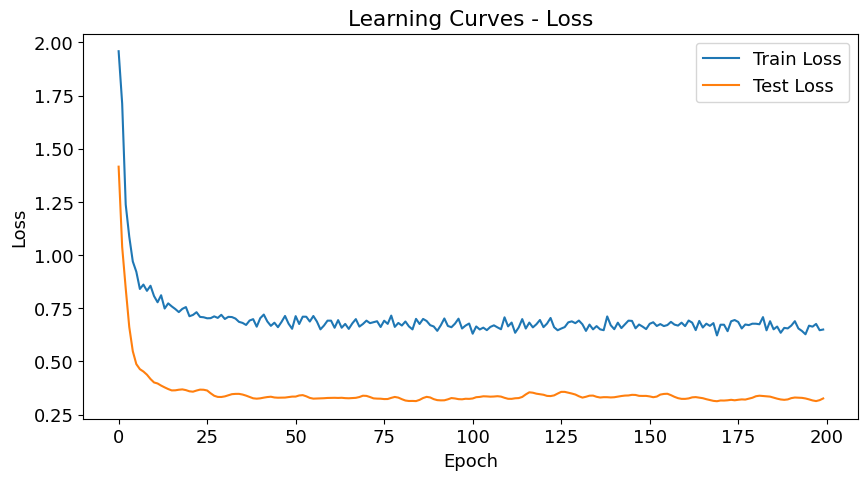

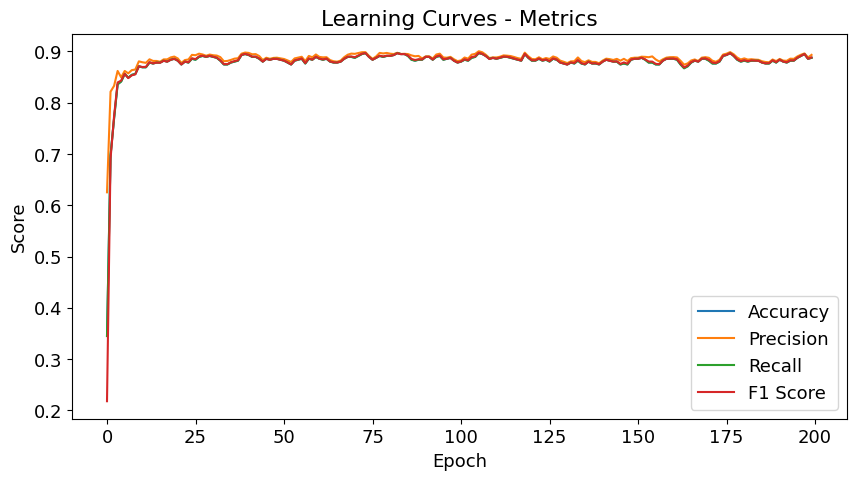

In [20]:
# Plot learning curves for loss
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Learning Curves - Loss')
plt.show()

# Plot learning curves for metrics (accuracy, precision, recall, F1 score)
plt.figure(figsize=(10, 5))
plt.plot(accuracies, label='Accuracy')
plt.plot(precisions, label='Precision')
plt.plot(recalls, label='Recall')
plt.plot(f1_scores, label='F1 Score')
plt.xlabel('Epoch')
plt.ylabel('Score')
plt.legend()
plt.title('Learning Curves - Metrics')
plt.show()



**Architecture of proposed model**

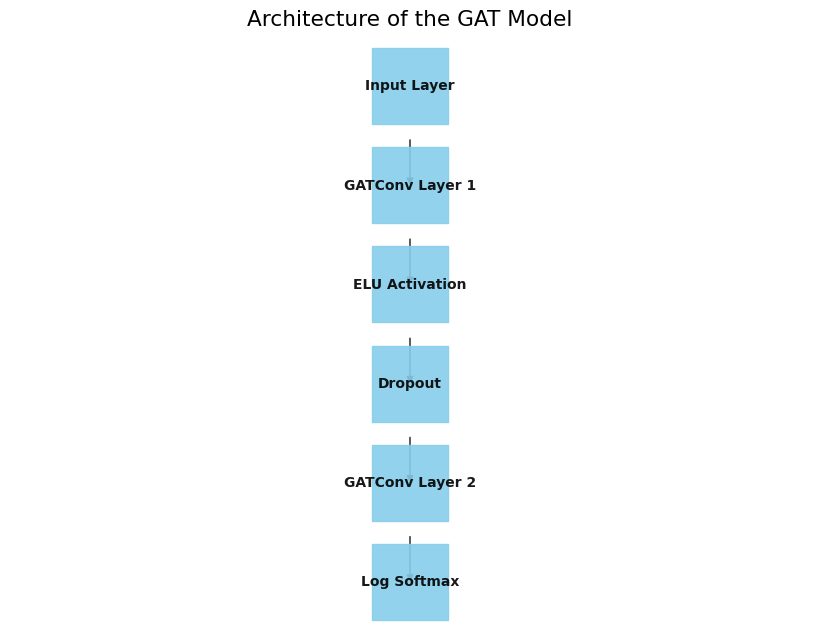

In [21]:
import networkx as nx
import matplotlib.pyplot as plt

def draw_gat_architecture():
    """
    Draw the architecture of a GAT (Graph Attention Network) model.
    This function creates a visualization of the layers and connections in a GAT model.

    The layers included in the visualization are:
    - Input Layer
    - GATConv Layer 1
    - ELU Activation
    - Dropout
    - GATConv Layer 2
    - Log Softmax

    Returns:
        None
    """
    G = nx.DiGraph()

    # Define the layers
    layers = ['Input Layer', 'GATConv Layer 1', 'ELU Activation', 'Dropout', 'GATConv Layer 2', 'Log Softmax']
    pos = {i: (0, -i) for i in range(len(layers))}

    # Add nodes for each layer
    for i, layer in enumerate(layers):
        G.add_node(layer, pos=pos[i])

    # Add edges between the layers
    for i in range(len(layers) - 1):
        G.add_edge(layers[i], layers[i + 1])

    # Draw the network
    pos = nx.get_node_attributes(G, 'pos')
    plt.figure(figsize=(8, 6))
    nx.draw(G, pos, with_labels=True, node_size=3000, node_color='skyblue', node_shape='s', alpha=0.9, font_size=10, font_weight='bold')
    plt.title('Architecture of the GAT Model')
    plt.show()

# Call the function to draw the GAT architecture
draw_gat_architecture()


**ABLATION STUDIES**

**ABLATION 1: Remove Dropout layer**

In [22]:
class GAT_NoDropout(torch.nn.Module):
    def __init__(self, hidden_channels, num_heads):
        """
        Initialize the GAT model without dropout.

        Args:
            hidden_channels (int): Number of hidden channels in the GATConv layers.
            num_heads (int): Number of attention heads in the GATConv layers.
        """
        super(GAT_NoDropout, self).__init__()
        self.conv1 = GATConv(dataset.num_features, hidden_channels, heads=num_heads, dropout=0.0)
        self.conv2 = GATConv(hidden_channels * num_heads, dataset.num_classes, heads=1, dropout=0.0)

    def forward(self, x, edge_index):
        """
        Perform a forward pass through the GAT model without dropout.

        Args:
            x (Tensor): Node features.
            edge_index (LongTensor): Edge indices.

        Returns:
            Tensor: Predicted log probabilities.
        """
        x = F.elu(self.conv1(x, edge_index))
        x = self.conv2(x, edge_index)
        return F.log_softmax(x, dim=1)

# Initialize and train the model
model_no_dropout = GAT_NoDropout(hidden_channels=64, num_heads=8).to(device)
optimizer = torch.optim.Adam(model_no_dropout.parameters(), lr=0.01, weight_decay=5e-4)

# Train and evaluate the model
train_losses_no_dropout, test_losses_no_dropout, accuracies_no_dropout = [], [], []
precisions_no_dropout, recalls_no_dropout, f1_scores_no_dropout = [], [], []

for epoch in range(1, 201):
    train_loss = train()
    test_loss, acc, pred, true = test()
    train_losses_no_dropout.append(train_loss)
    test_losses_no_dropout.append(test_loss)
    accuracies_no_dropout.append(acc)

    precision = precision_score(true.cpu(), pred.cpu(), average='weighted')
    recall = recall_score(true.cpu(), pred.cpu(), average='weighted')
    f1 = f1_score(true.cpu(), pred.cpu(), average='weighted')

    precisions_no_dropout.append(precision)
    recalls_no_dropout.append(recall)
    f1_scores_no_dropout.append(f1)

    print(f'[No Dropout] Epoch: {epoch:03d}, Loss: {train_loss:.4f}, Accuracy: {acc:.4f}')
    print(f'Precision: {precision:.4f}, Recall: {recall:.4f}, F1 Score: {f1:.4f}')



[No Dropout] Epoch: 001, Loss: 0.6292, Accuracy: 0.8875
Precision: 0.8932, Recall: 0.8875, F1 Score: 0.8881
[No Dropout] Epoch: 002, Loss: 0.6922, Accuracy: 0.8875
Precision: 0.8932, Recall: 0.8875, F1 Score: 0.8881
[No Dropout] Epoch: 003, Loss: 0.6899, Accuracy: 0.8875
Precision: 0.8932, Recall: 0.8875, F1 Score: 0.8881
[No Dropout] Epoch: 004, Loss: 0.6821, Accuracy: 0.8875
Precision: 0.8932, Recall: 0.8875, F1 Score: 0.8881
[No Dropout] Epoch: 005, Loss: 0.6748, Accuracy: 0.8875
Precision: 0.8932, Recall: 0.8875, F1 Score: 0.8881
[No Dropout] Epoch: 006, Loss: 0.6712, Accuracy: 0.8875
Precision: 0.8932, Recall: 0.8875, F1 Score: 0.8881
[No Dropout] Epoch: 007, Loss: 0.6448, Accuracy: 0.8875
Precision: 0.8932, Recall: 0.8875, F1 Score: 0.8881
[No Dropout] Epoch: 008, Loss: 0.6579, Accuracy: 0.8875
Precision: 0.8932, Recall: 0.8875, F1 Score: 0.8881
[No Dropout] Epoch: 009, Loss: 0.6600, Accuracy: 0.8875
Precision: 0.8932, Recall: 0.8875, F1 Score: 0.8881
[No Dropout] Epoch: 010, Los

**ABLATION 2: Change in activation function**

In [23]:
class GAT_ReLU(torch.nn.Module):
    def __init__(self, hidden_channels, num_heads, dropout):
        """
        Initialize the GAT model with ReLU activation and dropout.

        Args:
            hidden_channels (int): Number of hidden channels in the GATConv layers.
            num_heads (int): Number of attention heads in the GATConv layers.
            dropout (float): Dropout probability.
        """
        super(GAT_ReLU, self).__init__()
        self.conv1 = GATConv(dataset.num_features, hidden_channels, heads=num_heads, dropout=dropout)
        self.conv2 = GATConv(hidden_channels * num_heads, dataset.num_classes, heads=1, dropout=dropout)

    def forward(self, x, edge_index):
        """
        Perform a forward pass through the GAT model with ReLU activation and dropout.

        Args:
            x (Tensor): Node features.
            edge_index (LongTensor): Edge indices.

        Returns:
            Tensor: Predicted log probabilities.
        """
        x = F.dropout(x, p=0.6, training=self.training)
        x = F.relu(self.conv1(x, edge_index))
        x = F.dropout(x, p=0.6, training=self.training)
        x = self.conv2(x, edge_index)
        return F.log_softmax(x, dim=1)

# Initialize and train the model
model_relu = GAT_ReLU(hidden_channels=64, num_heads=8, dropout=0.6).to(device)
optimizer = torch.optim.Adam(model_relu.parameters(), lr=0.01, weight_decay=5e-4)

# Train and evaluate the model
train_losses_relu, test_losses_relu, accuracies_relu = [], [], []
precisions_relu, recalls_relu, f1_scores_relu = [], [], []

for epoch in range(1, 201):
    train_loss = train()
    test_loss, acc, pred, true = test()
    train_losses_relu.append(train_loss)
    test_losses_relu.append(test_loss)
    accuracies_relu.append(acc)

    precision = precision_score(true.cpu(), pred.cpu(), average='weighted')
    recall = recall_score(true.cpu(), pred.cpu(), average='weighted')
    f1 = f1_score(true.cpu(), pred.cpu(), average='weighted')

    precisions_relu.append(precision)
    recalls_relu.append(recall)
    f1_scores_relu.append(f1)

    print(f'[ReLU Activation] Epoch: {epoch:03d}, Loss: {train_loss:.4f}, Accuracy: {acc:.4f}')
    print(f'Precision: {precision:.4f}, Recall: {recall:.4f}, F1 Score: {f1:.4f}')


[ReLU Activation] Epoch: 001, Loss: 0.6627, Accuracy: 0.8875
Precision: 0.8932, Recall: 0.8875, F1 Score: 0.8881
[ReLU Activation] Epoch: 002, Loss: 0.6897, Accuracy: 0.8875
Precision: 0.8932, Recall: 0.8875, F1 Score: 0.8881
[ReLU Activation] Epoch: 003, Loss: 0.6328, Accuracy: 0.8875
Precision: 0.8932, Recall: 0.8875, F1 Score: 0.8881
[ReLU Activation] Epoch: 004, Loss: 0.6523, Accuracy: 0.8875
Precision: 0.8932, Recall: 0.8875, F1 Score: 0.8881
[ReLU Activation] Epoch: 005, Loss: 0.6815, Accuracy: 0.8875
Precision: 0.8932, Recall: 0.8875, F1 Score: 0.8881
[ReLU Activation] Epoch: 006, Loss: 0.6646, Accuracy: 0.8875
Precision: 0.8932, Recall: 0.8875, F1 Score: 0.8881
[ReLU Activation] Epoch: 007, Loss: 0.6675, Accuracy: 0.8875
Precision: 0.8932, Recall: 0.8875, F1 Score: 0.8881
[ReLU Activation] Epoch: 008, Loss: 0.6462, Accuracy: 0.8875
Precision: 0.8932, Recall: 0.8875, F1 Score: 0.8881
[ReLU Activation] Epoch: 009, Loss: 0.6707, Accuracy: 0.8875
Precision: 0.8932, Recall: 0.8875, 

**ABLATION 3:Reduce Number of Attention Heads**

In [24]:
class GAT_FewerHeads(torch.nn.Module):
    def __init__(self, hidden_channels, dropout):
        """
        Initialize the GAT model with fewer attention heads.

        Args:
            hidden_channels (int): Number of hidden channels in the GATConv layers.
            dropout (float): Dropout probability.
        """
        super(GAT_FewerHeads, self).__init__()
        self.conv1 = GATConv(dataset.num_features, hidden_channels, heads=4, dropout=dropout)
        self.conv2 = GATConv(hidden_channels * 4, dataset.num_classes, heads=1, dropout=dropout)

    def forward(self, x, edge_index):
        """
        Perform a forward pass through the GAT model with fewer attention heads.

        Args:
            x (Tensor): Node features.
            edge_index (LongTensor): Edge indices.

        Returns:
            Tensor: Predicted log probabilities.
        """
        x = F.dropout(x, p=0.6, training=self.training)
        x = F.elu(self.conv1(x, edge_index))
        x = F.dropout(x, p=0.6, training=self.training)
        x = self.conv2(x, edge_index)
        return F.log_softmax(x, dim=1)

# Initialize and train the model
model_fewer_heads = GAT_FewerHeads(hidden_channels=64, dropout=0.6).to(device)
optimizer = torch.optim.Adam(model_fewer_heads.parameters(), lr=0.01, weight_decay=5e-4)

# Train and evaluate the model
train_losses_fewer_heads, test_losses_fewer_heads, accuracies_fewer_heads = [], [], []
precisions_fewer_heads, recalls_fewer_heads, f1_scores_fewer_heads = [], [], []

for epoch in range(1, 201):
    model_fewer_heads.train()
    optimizer.zero_grad()
    out = model_fewer_heads(data.x, data.edge_index)
    loss = F.nll_loss(out[data.train_mask], data.y[data.train_mask])
    loss.backward()
    optimizer.step()
    train_losses_fewer_heads.append(loss.item())

    model_fewer_heads.eval()
    out = model_fewer_heads(data.x, data.edge_index)
    pred = out.argmax(dim=1)
    test_loss = F.nll_loss(out[data.test_mask], data.y[data.test_mask]).item()
    acc = (pred[data.test_mask] == data.y[data.test_mask]).sum().item() / data.test_mask.sum().item()
    test_losses_fewer_heads.append(test_loss)
    accuracies_fewer_heads.append(acc)

    precision = precision_score(data.y[data.test_mask].cpu(), pred[data.test_mask].cpu(), average='weighted')
    recall = recall_score(data.y[data.test_mask].cpu(), pred[data.test_mask].cpu(), average='weighted')
    f1 = f1_score(data.y[data.test_mask].cpu(), pred[data.test_mask].cpu(), average='weighted')

    precisions_fewer_heads.append(precision)
    recalls_fewer_heads.append(recall)
    f1_scores_fewer_heads.append(f1)

    print(f'[Fewer Heads] Epoch: {epoch:03d}, Loss: {loss:.4f}, Accuracy: {acc:.4f}')
    print(f'Precision: {precision:.4f}, Recall: {recall:.4f}, F1 Score: {f1:.4f}')



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[Fewer Heads] Epoch: 001, Loss: 1.9936, Accuracy: 0.3672
Precision: 0.5685, Recall: 0.3672, F1 Score: 0.2555
[Fewer Heads] Epoch: 002, Loss: 1.6132, Accuracy: 0.7380
Precision: 0.7881, Recall: 0.7380, F1 Score: 0.6929
[Fewer Heads] Epoch: 003, Loss: 1.2724, Accuracy: 0.8118
Precision: 0.8400, Recall: 0.8118, F1 Score: 0.8112
[Fewer Heads] Epoch: 004, Loss: 1.1396, Accuracy: 0.8432
Precision: 0.8558, Recall: 0.8432, F1 Score: 0.8438
[Fewer Heads] Epoch: 005, Loss: 0.9840, Accuracy: 0.8542
Precision: 0.8630, Recall: 0.8542, F1 Score: 0.8544
[Fewer Heads] Epoch: 006, Loss: 0.9342, Accuracy: 0.8579
Precision: 0.8653, Recall: 0.8579, F1 Score: 0.8575
[Fewer Heads] Epoch: 007, Loss: 0.8819, Accuracy: 0.8506
Precision: 0.8595, Recall: 0.8506, F1 Score: 0.8503
[Fewer Heads] Epoch: 008, Loss: 0.8988, Accuracy: 0.8616
Precision: 0.8669, Recall: 0.8616, F1 Score: 0.8612
[Fewer Heads] Epoch: 009, Loss: 0.9035, Accuracy: 0.8727
Precision: 0.8752, Recall: 0.8727, F1 Score: 0.8722
[Fewer Heads] Epoch